# Notebook to compute polynomial fits
Written by Anne Sofie Luise Zarda (anne.zarda@epfl.ch)

In [1]:
import numpy as np
import pandas as pd
from math import sqrt
from pathlib import Path

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate

import matplotlib.pyplot as plt
import seaborn as sns

from cyc_pep_perm.data.paths import TRAIN_RANDOM_DW, ROOT_PATH, TEST_RANDOM_DW

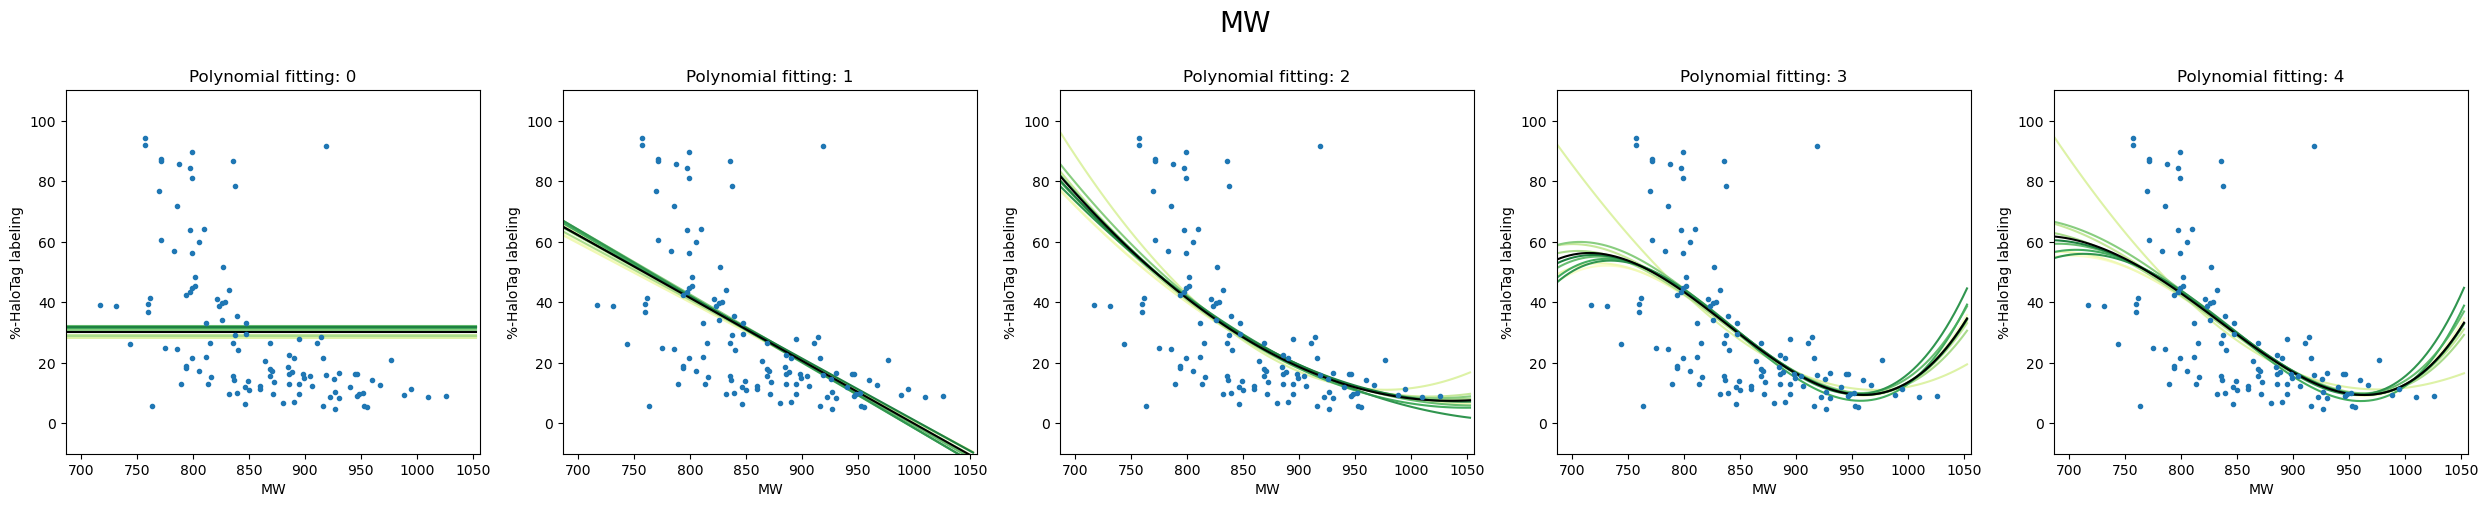

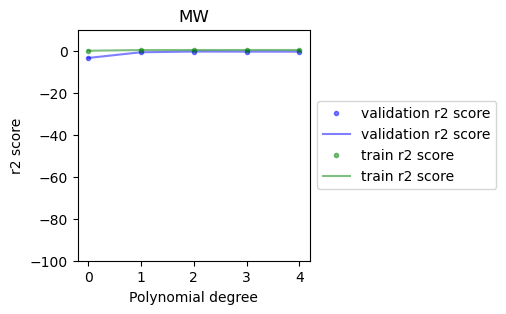

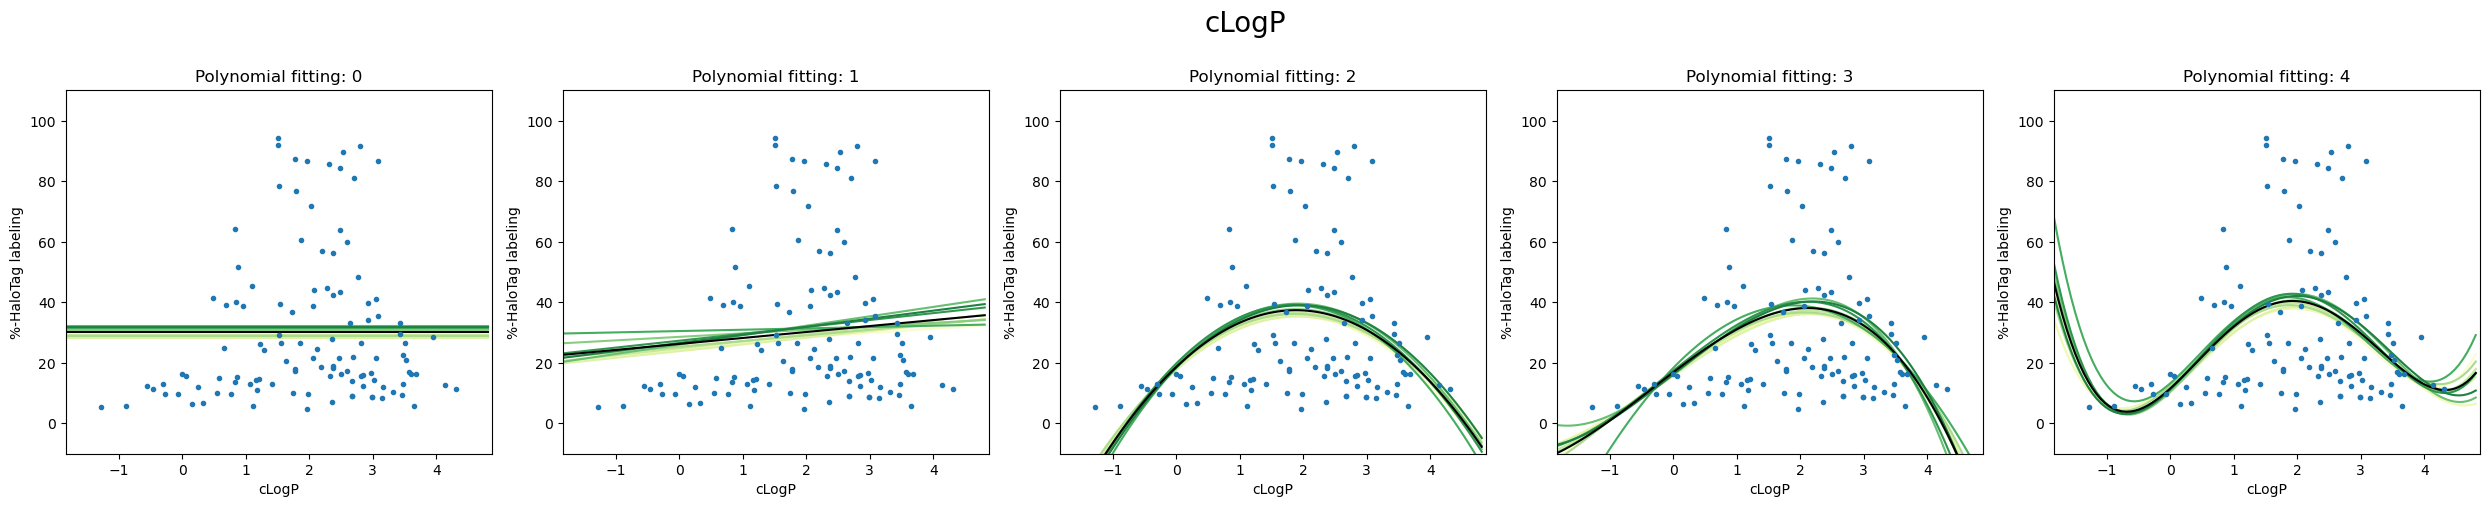

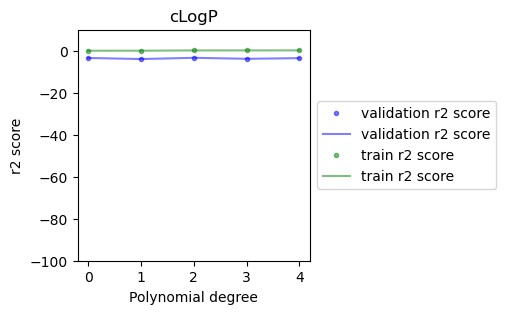

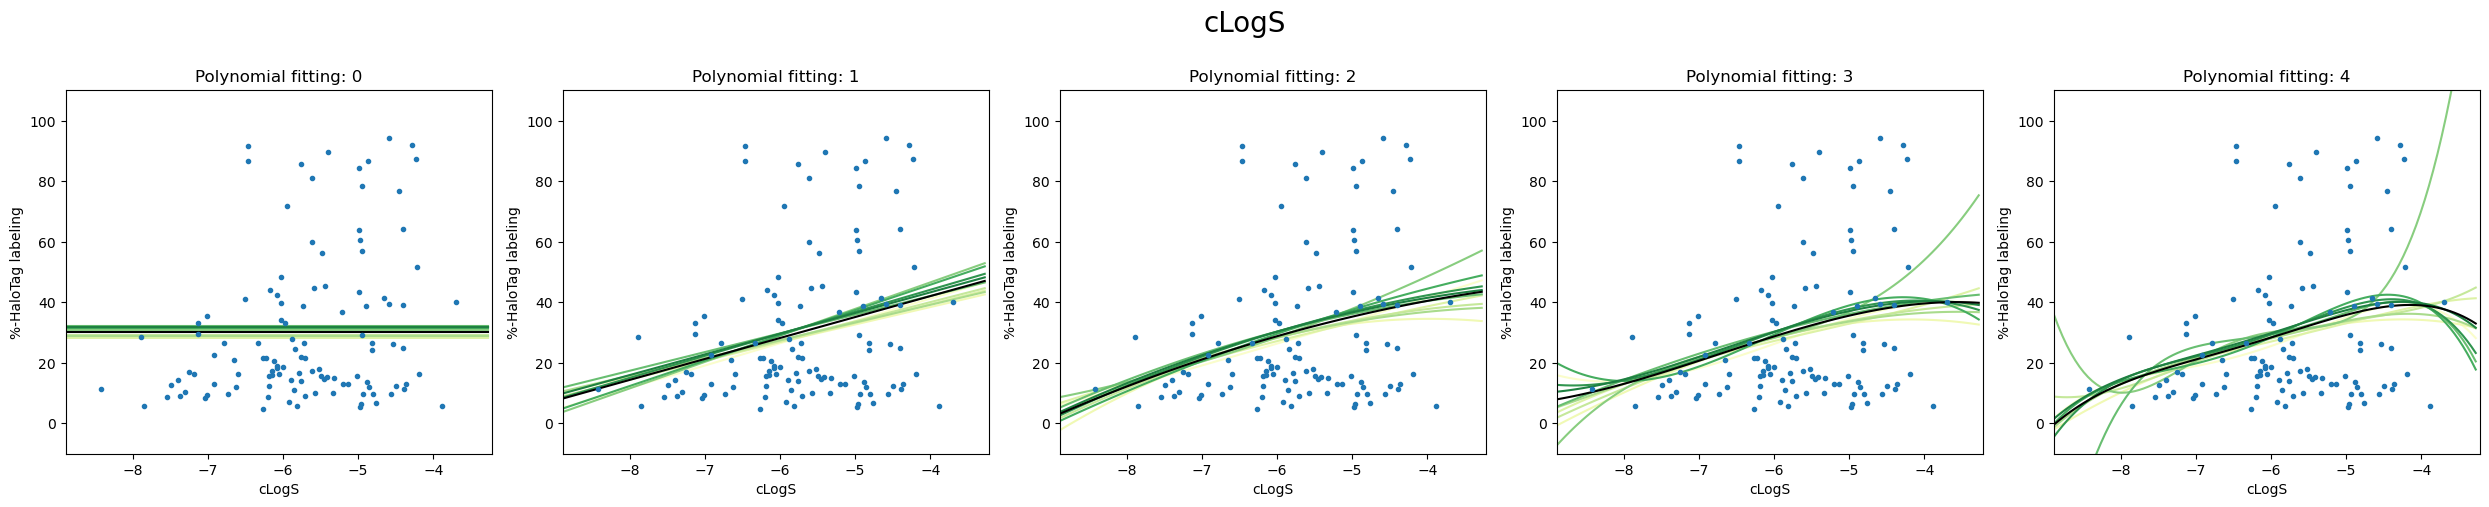

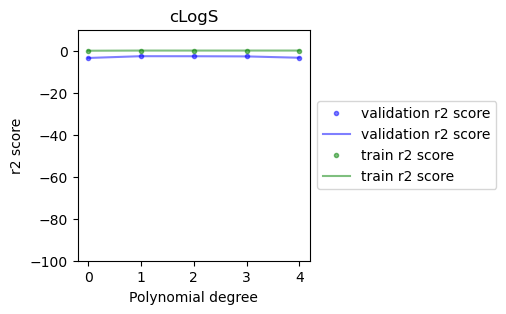

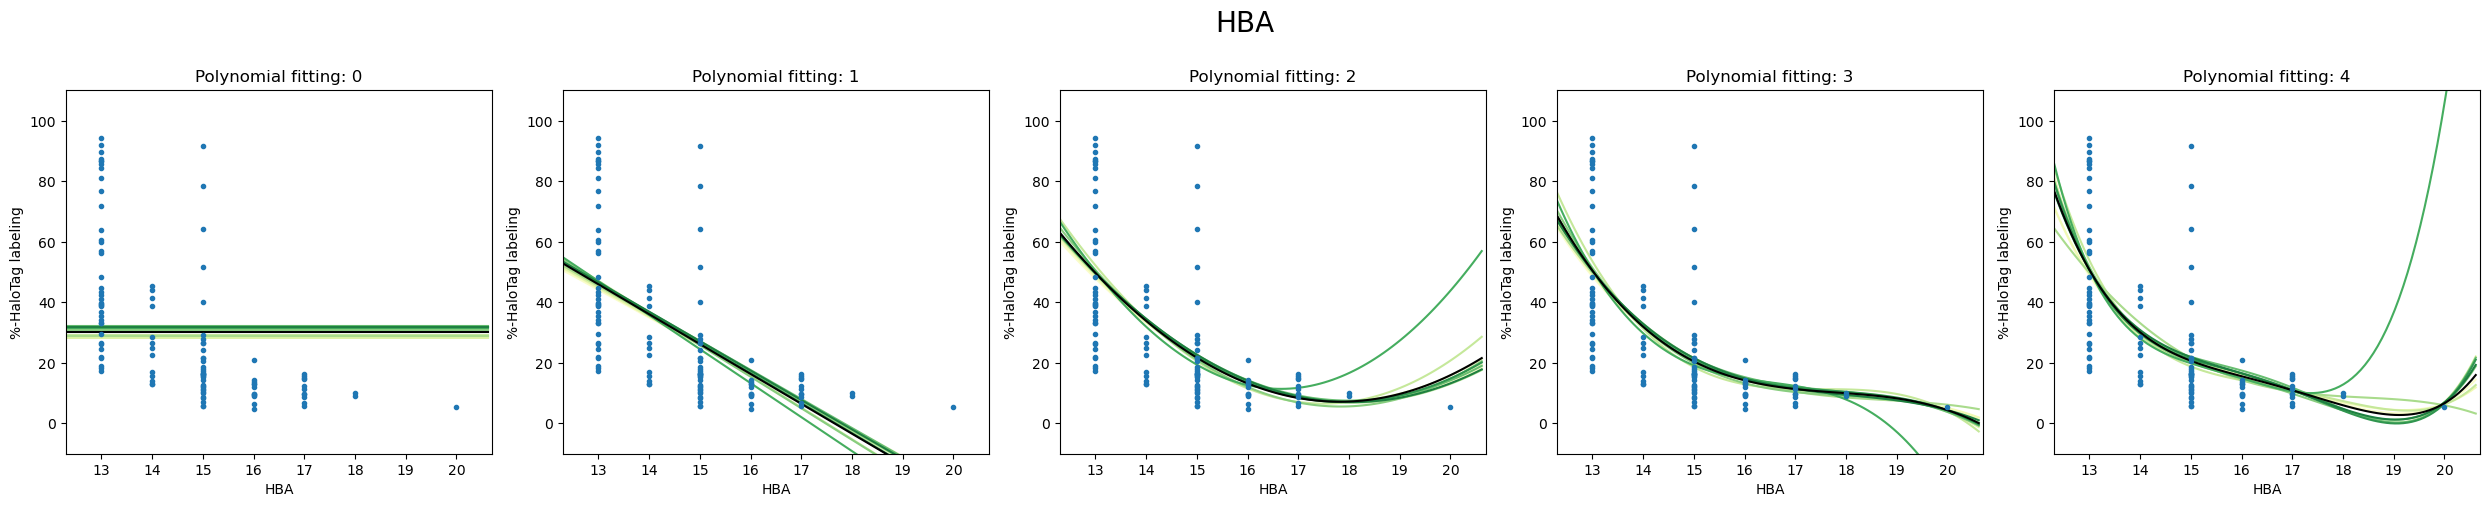

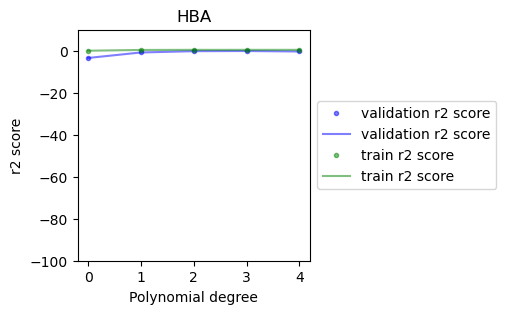

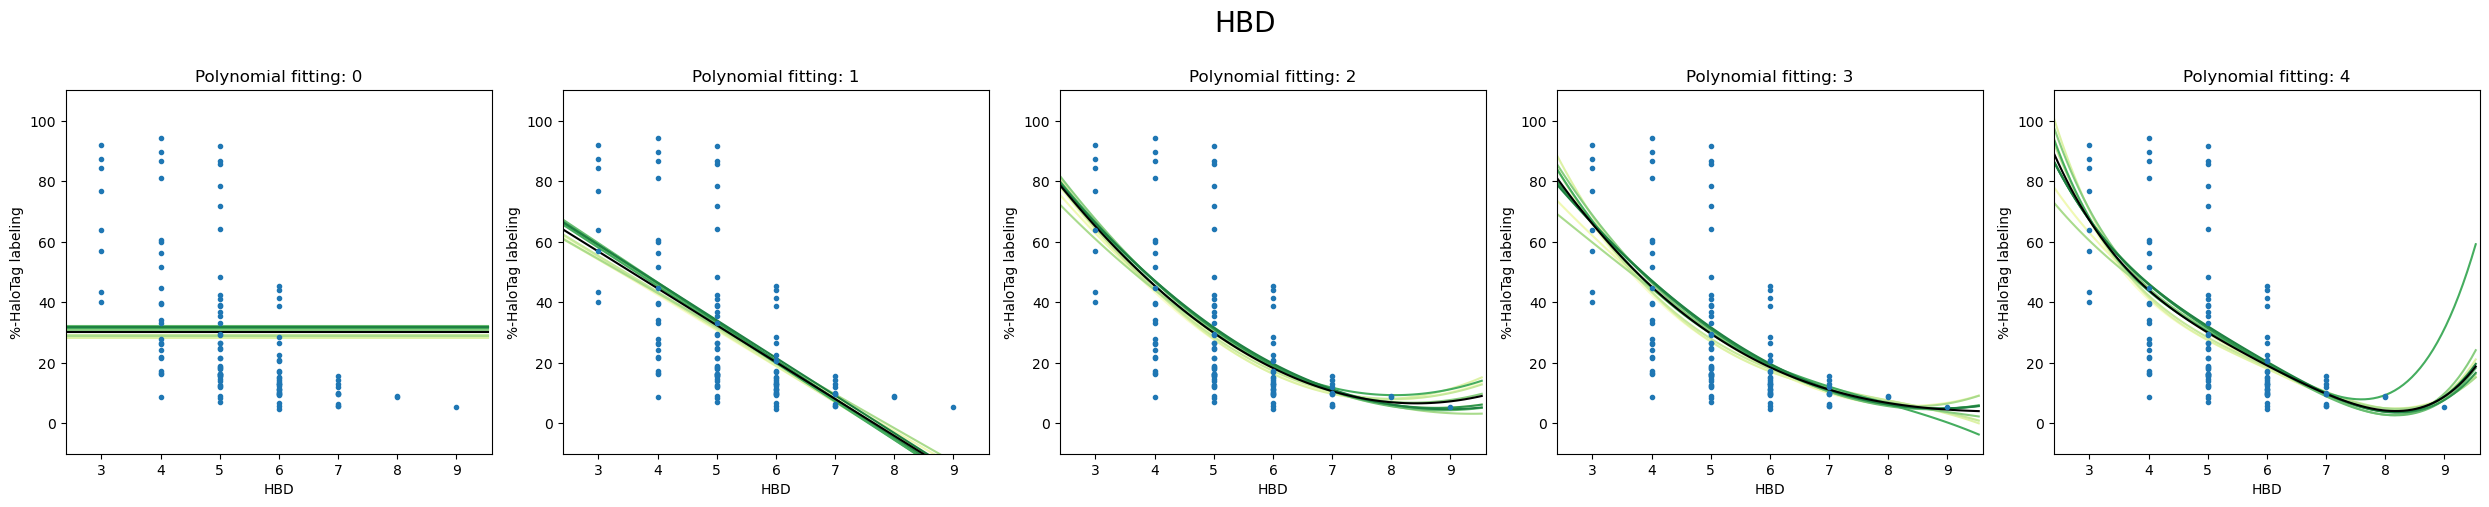

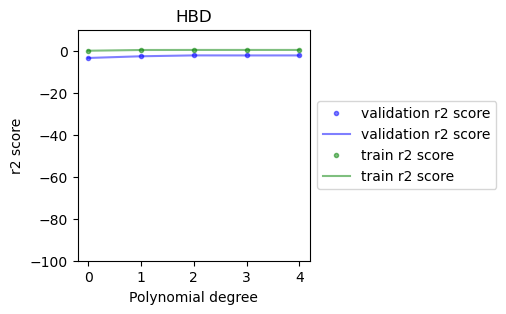

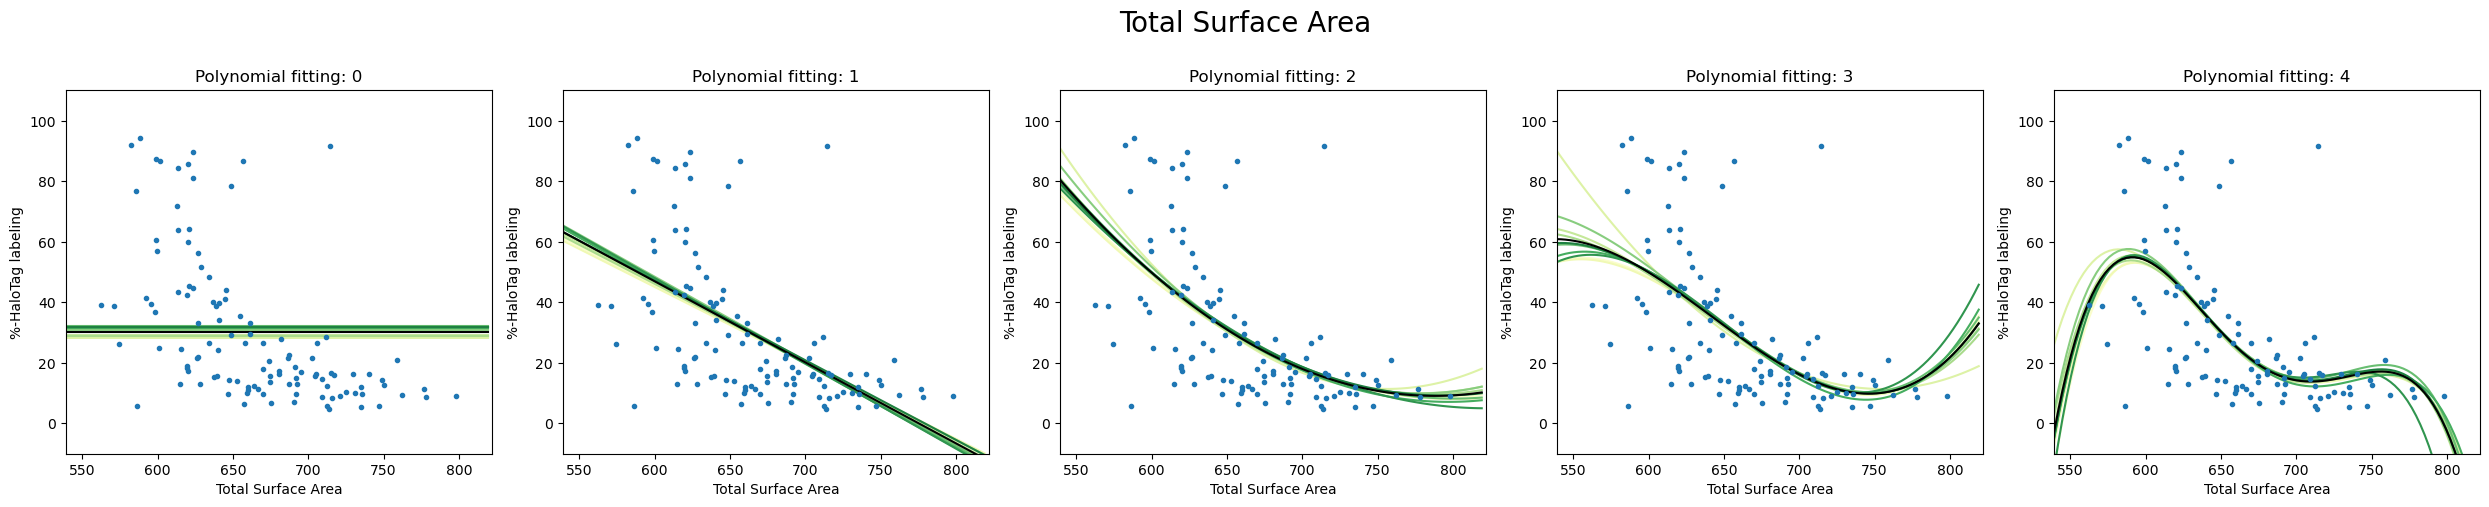

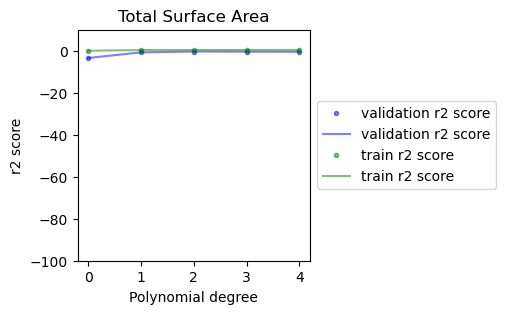

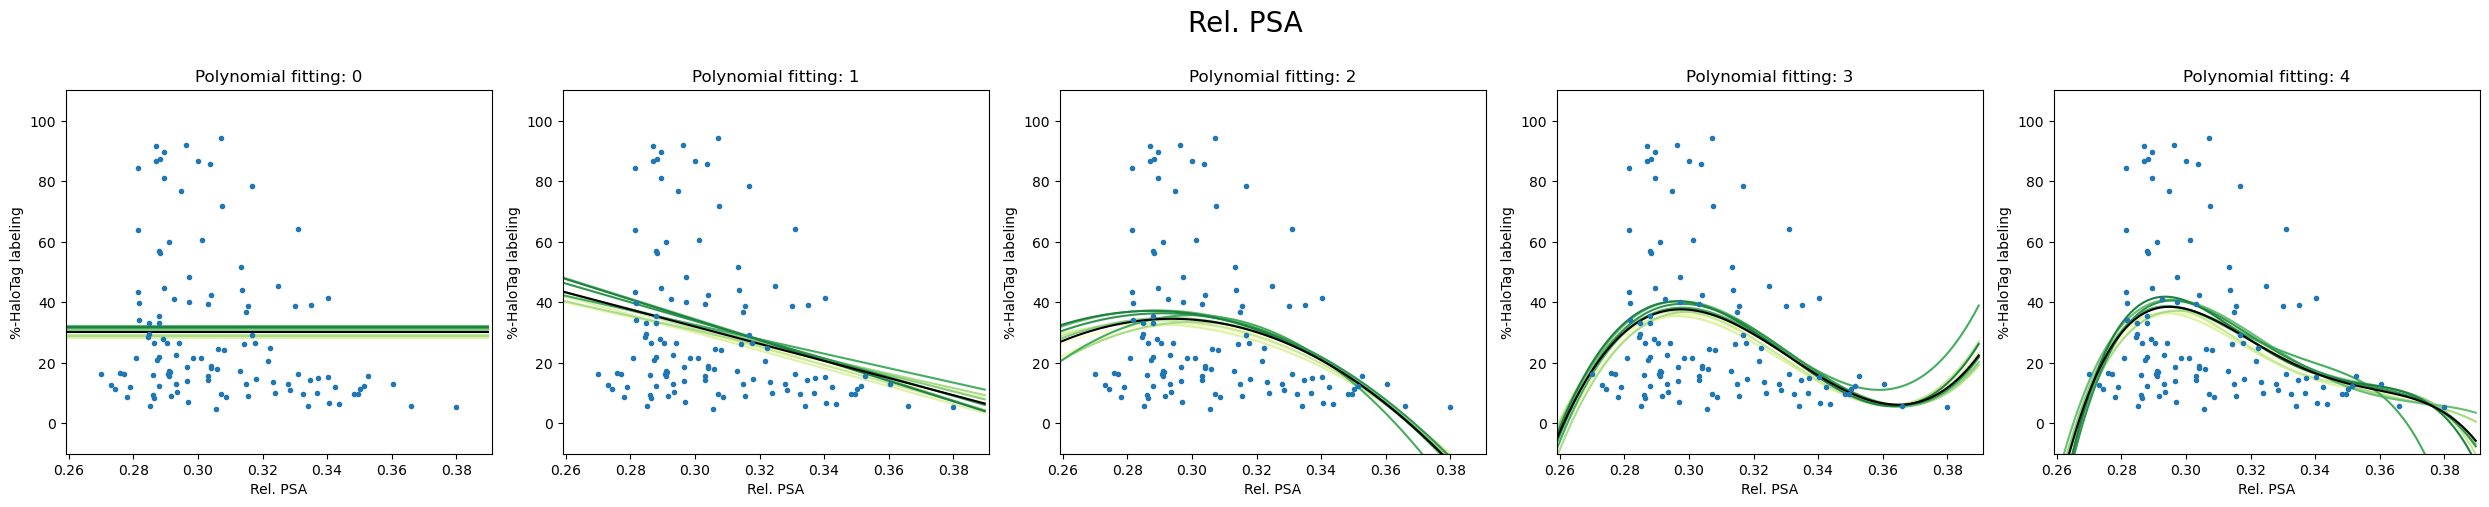

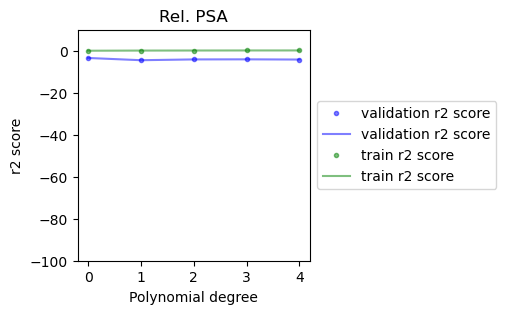

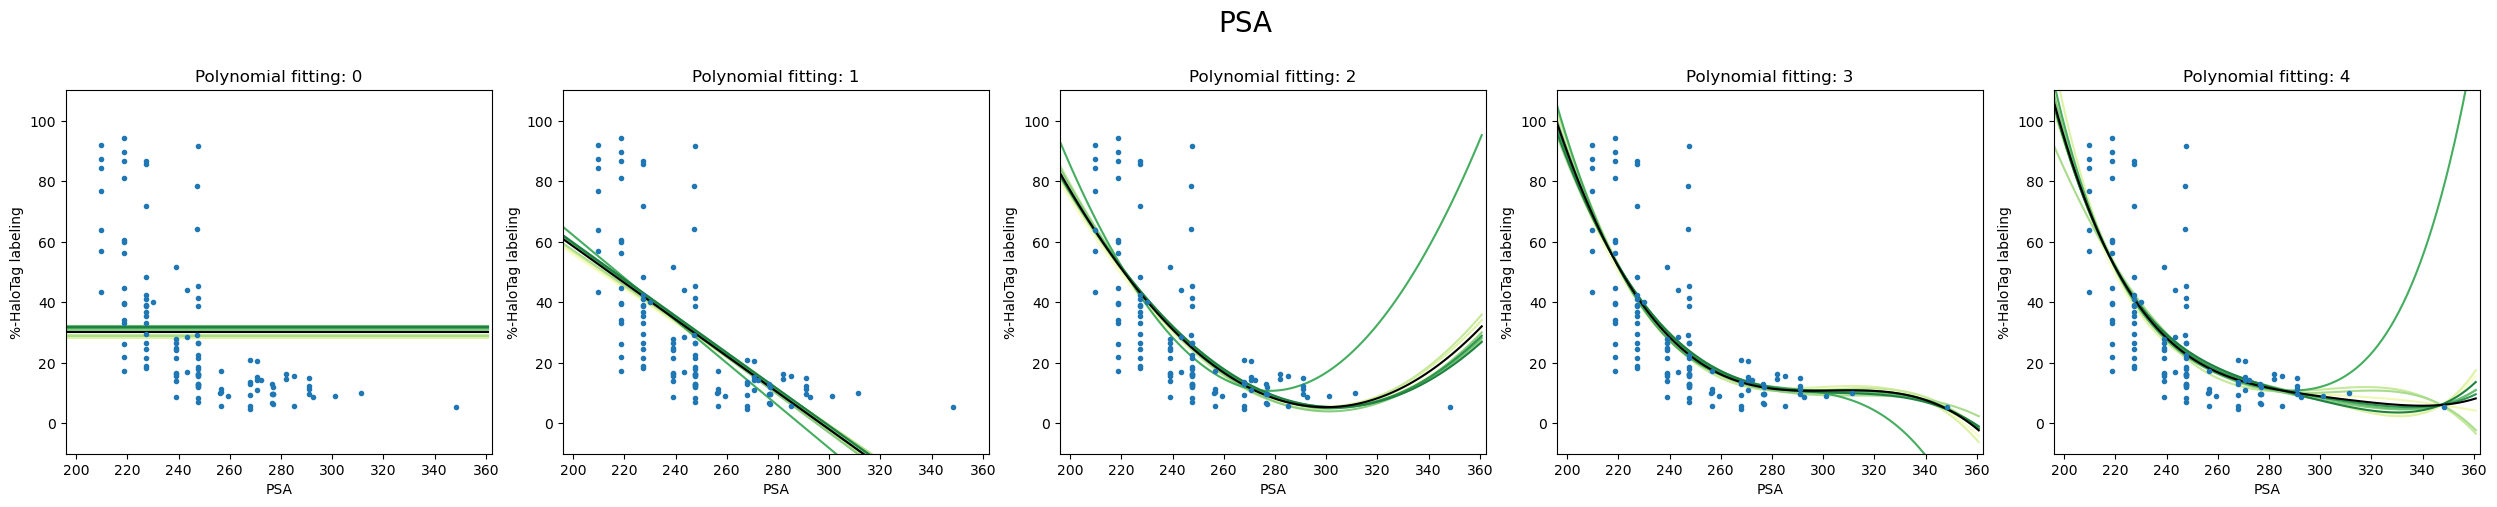

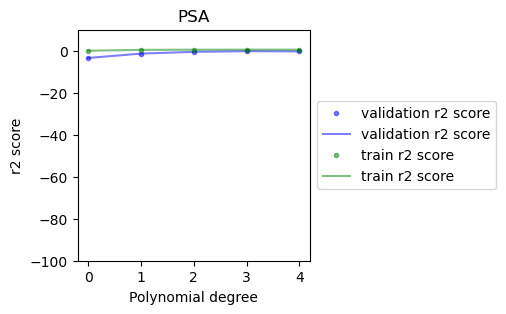

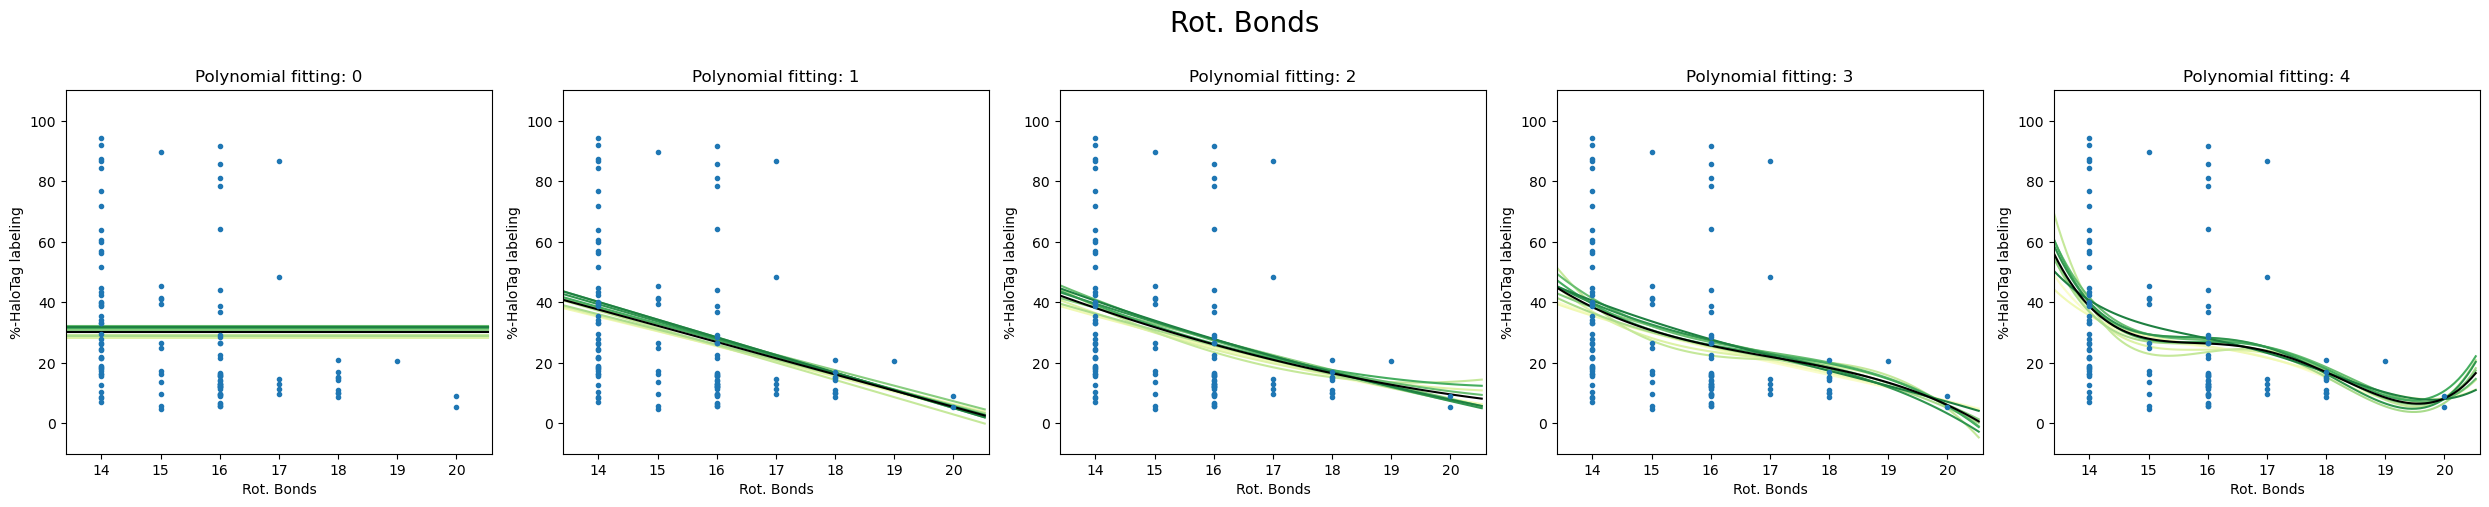

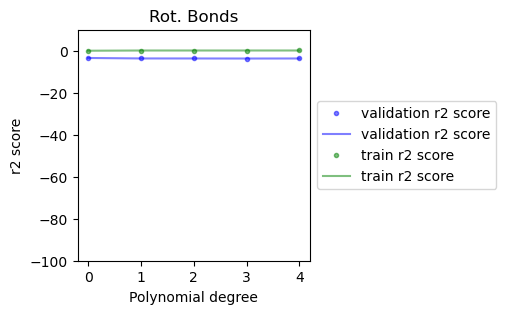

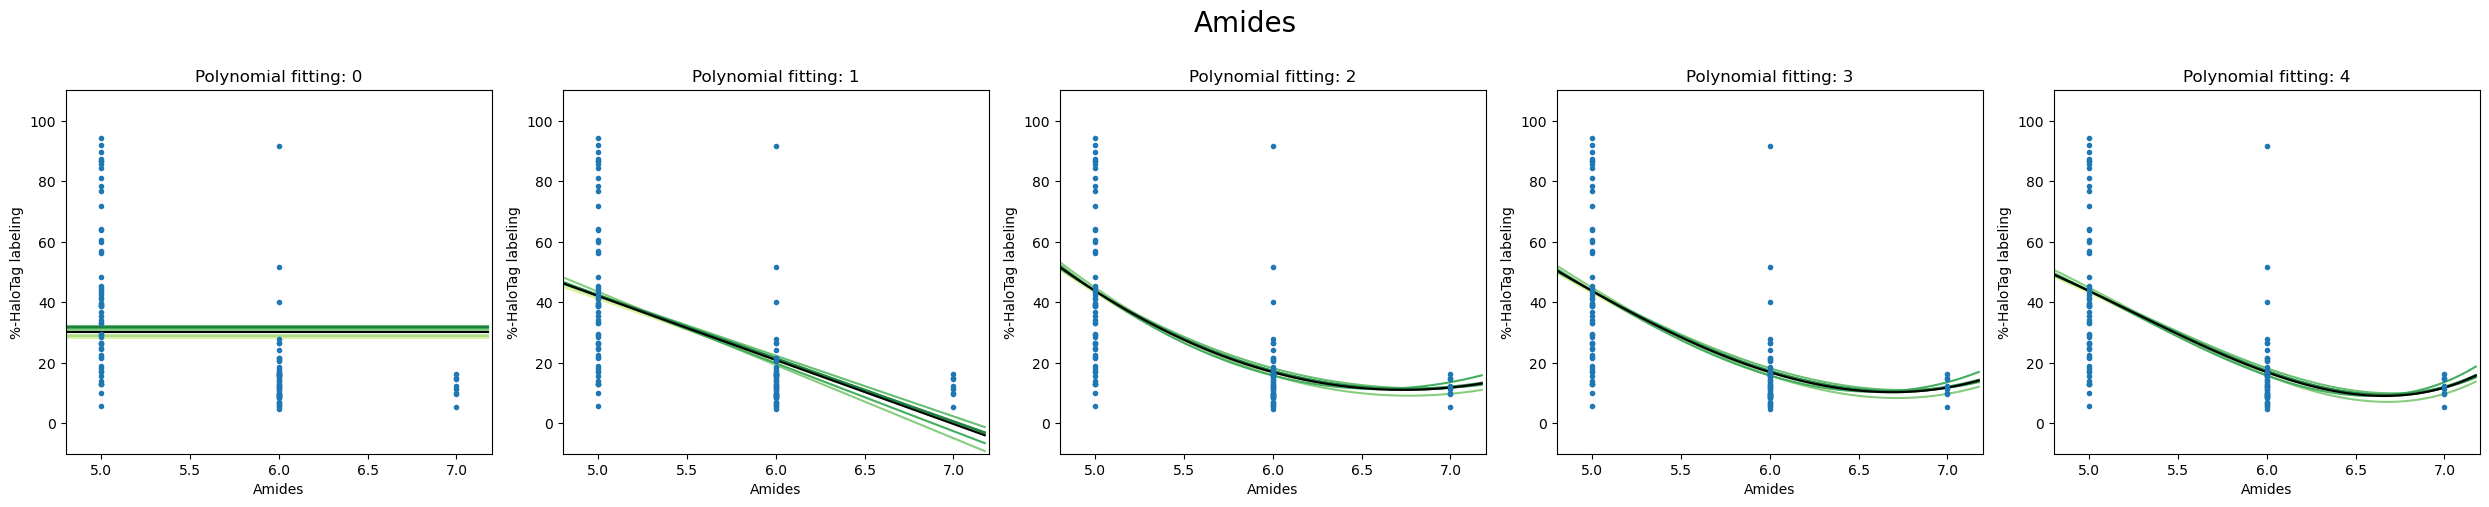

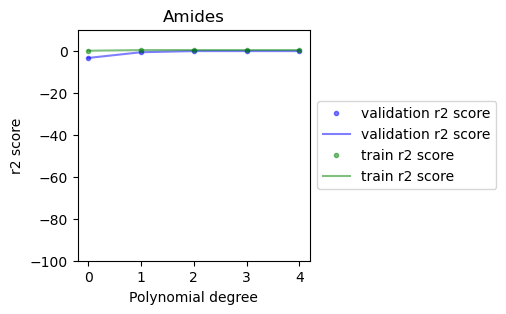

In [2]:
## cross validation to determine which polynomial fit should be used

df = pd.read_csv(TRAIN_RANDOM_DW)
# rename column
df = df.rename(columns={'target': 'CAPA [1 µM]'})

savedir = Path(ROOT_PATH, 'figures')
savedir.mkdir(exist_ok=True)

xes = ['MW', 'cLogP', 'cLogS', 'HBA', 'HBD',
       'Total Surface Area', 'Rel. PSA', 'PSA', 'Rot. Bonds', 'Amides'] #properties that are fit against permeability (will be x in the fitting)

dfest = pd.DataFrame(columns=['type'] + [i for i in range(5)]) #dataframe to collect estimators

dfr2train = pd.DataFrame(columns=['type'] + [i for i in range(5)]) #dataframe to collect r2 scores on training set

dfr2validation = pd.DataFrame(columns=['type'] + [i for i in range(5)]) #dataframe to collect r2 scores on validation set

for thing in xes:

    x_raw = df[thing]
    y_raw = df['CAPA [1 µM]']

    x = df[thing].array.reshape(-1, 1)
    y = df['CAPA [1 µM]'].array.reshape(-1, 1)

    xmin = min(x_raw)-0.1*(max(x_raw) - min(x_raw))
    xmax = max(x_raw) + 0.1*(max(x_raw) - min(x_raw))

    xp = np.arange(xmin, xmax, (xmax-xmin)/100).reshape(-1,1) #a dummy array to plot the fits

    #print(x.shape)
    #print(y.shape)

    results = {}

    r2s_validation = [] #list to collect r2 scores on validation set
    r2s_train = [] #list to collect r2 scores on training set
    estimators = [] #list to collect estimators

    colors = sns.color_palette("YlGn", n_colors=12, as_cmap=False)

    fig, axn = plt.subplots(1,5,figsize=(25,5))

    for d in range(5):
        # print('Polynomial degree: ' + str(d))
        x_poly=PolynomialFeatures(degree=d).fit_transform(x) #Featurization of x
        lr=LinearRegression(fit_intercept=False) #linear regression model
        model=lr.fit(x_poly,y) #fit linear regression

        estimators.append(model) #save fit to list

        # display(model.coef_)
        # display(model.intercept_)

        # # cross validation of fit
        cvs = 10
        cve=cross_validate(lr, x_poly, y, cv=cvs, scoring = 'r2', return_train_score=True, return_estimator=True)
        r2s_validation.append(np.mean(cve['test_score'])) #save mean r2 scores from validation set
        r2s_train.append(np.mean(cve['train_score'])) #save mean r2 scores from train set
        # display(cve)

        if d%1 == 0: #this can be adjusted if not all fits should be plotted (for example only every second, third, fourth, ...)
            for cvidx in range(cvs):
                axn.flat[d].plot(xp, cve['estimator'][cvidx].predict(PolynomialFeatures(degree=d).fit_transform(xp)), '-', color=colors[cvidx]) #plot each fit from the cross validation
            axn.flat[d].plot(xp, model.predict(PolynomialFeatures(degree=d).fit_transform(xp)), '-', color = 'black') #plot fit from whole training set
            axn.flat[d].plot(x_raw, y_raw, '.') #plot experimental values
            axn.flat[d].set_ylim(-10, 110)
            axn.flat[d].set_xlim(xmin, xmax)
            axn.flat[d].set_xlabel(thing)
            axn.flat[d].set_ylabel('%-HaloTag labeling')
            axn.flat[d].set_title('Polynomial fitting: ' + str(d))

    fig.suptitle(thing, y = 1.005, fontsize = 20)
    fig.tight_layout()
    plt.savefig(Path(savedir, f'cv_{thing}.jpg'), bbox_inches='tight', dpi=400)
    plt.show()

    #plot of mean r2 scores for validation set (blue) and training set (green)
    fig, axn = plt.subplots(1,1,figsize=(3,3))
    axn.plot(range(len(r2s_validation)), r2s_validation, '.', label='validation r2 score', alpha = 0.5, color = 'blue')
    axn.plot(range(len(r2s_validation)), r2s_validation, '-', label='validation r2 score', alpha = 0.5, color = 'blue')
    axn.plot(range(len(r2s_train)), r2s_train, '.', label = 'train r2 score', alpha = 0.5, color = 'green')
    axn.plot(range(len(r2s_train)), r2s_train, '-', label = 'train r2 score', alpha = 0.5, color = 'green')
    axn.set_xlabel('Polynomial degree')
    axn.set_ylabel('r2 score')
    axn.set_title(thing)
    axn.set_ylim(-100,10)
    axn.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # plt.savefig(Path(savedir, f'cv_scores_{thing}.jpg'), bbox_inches='tight', dpi=400)
    plt.show()

    dfest.loc[len(dfest.index)] = [thing] + estimators #save estimators
    dfr2train.loc[len(dfr2train.index)] = [thing] + r2s_train #save mean r2 scores from training set
    dfr2validation.loc[len(dfr2validation.index)] = [thing] + r2s_validation #save mean r2 scores from validation set

In [3]:
dfest.set_index('type', inplace = True)
dfr2validation.set_index('type', inplace = True)
dfr2train.set_index('type', inplace = True)
#display(dfest, dfr2validation, dfr2train)


In [4]:
#write all polynomial estimators to excel file

resultpath = Path(ROOT_PATH, 'results')
resultpath.mkdir(exist_ok=True)

dfcoef = pd.DataFrame(columns=['type', 'degree'] + [i for i in range(5)]) #create empty dataframe

rows = dfest.index.values.tolist()
cols = [i for i in dfest]

for row in rows:
    #print(row)
    for col in cols:
        #print(col)
        coeffs = [i for i in dfest.loc[row, col].coef_.tolist()[0]]
        #print(coeffs)
        newrow = [row] + [col] + coeffs + [0 for i in range(5-len(coeffs))]
        #print(newrow)
        dfcoef.loc[len(dfcoef.index)] = newrow
        #display(dfcoef)

display(dfcoef)
dfcoef.to_csv(Path(resultpath, 'coefs.csv'))

,type,degree,0,1,2,3,4
0,MW,0,30.182682,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
1,MW,1,207.369793,-0.207384,0.000000e+00,0.000000e+00,0.000000e+00
2,MW,2,661.413157,-1.262936,6.097735e-04,0.000000e+00,0.000000e+00
3,MW,3,-3496.480587,13.210236,-1.610765e-02,6.407432e-06,0.000000e+00
4,MW,4,-0.010509,-2.264764,9.421987e-03,-1.219658e-05,5.052183e-09
5,cLogP,0,30.182682,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
6,cLogP,1,26.257301,1.968974,0.000000e+00,0.000000e+00,0.000000e+00
7,cLogP,2,18.705790,19.844463,-5.269892e+00,0.000000e+00,0.000000e+00
8,cLogP,3,16.921629,15.961447,-9.063266e-01,-9.020538e-01,0.000000e+00
9,cLogP,4,11.601789,19.038195,6.684503e+00,-6.168166e+00,8.318784e-01


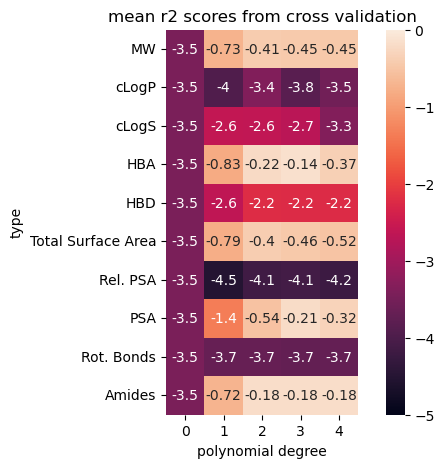

In [5]:
#plot heatmap with mean r2 validation test scores

plt.subplots(1,1, figsize = (7,5))
sns.heatmap(data = dfr2validation, vmin = -5, vmax= 0, square=True, annot=True)
plt.title('mean r2 scores from cross validation')
plt.xlabel('polynomial degree')
plt.savefig(Path(resultpath, f'cvevalidationr2score.jpg'), bbox_inches='tight', dpi=600)
dfr2validation.to_csv(Path(resultpath, 'dfr2validation.csv'))


In [6]:
#find best polynomial degree for each fit

bestvalidation = dfr2validation.idxmax(axis = 1)

print(bestvalidation)

bestfit_dict = {} #dictionary to save best estimator as determined by cross validation

for thing in bestvalidation.index:
    print(thing)
    display(dfest.loc[thing, bestvalidation[thing]].coef_)
    bestfit_dict[thing] = dfest.loc[thing, bestvalidation[thing]] #save estimator to dictionary

type
MW                    2
cLogP                 2
cLogS                 1
HBA                   3
HBD                   2
Total Surface Area    2
Rel. PSA              0
PSA                   3
Rot. Bonds            0
Amides                3
dtype: int64
MW


array([[ 6.61413157e+02, -1.26293622e+00,  6.09773514e-04]])

cLogP


array([[18.70578959, 19.84446264, -5.26989189]])

cLogS


array([[69.74440004,  6.92290297]])

HBA


array([[ 1.77746418e+03, -2.95170300e+02,  1.64992425e+01,
        -3.08670503e-01]])

HBD


array([[147.62147249, -33.47786537,   1.98738623]])

Total Surface Area


array([[ 7.25487381e+02, -1.81879132e+00,  1.15440935e-03]])

Rel. PSA


array([[30.18268155]])

PSA


array([[ 2.04012177e+03, -2.01025300e+01,  6.63379110e-02,
        -7.29239941e-05]])

Rot. Bonds


array([[30.18268155]])

Amides


array([[ 46.56742527,  86.60860756, -28.3255825 ,   2.17781218]])

In [8]:
#Testing

#import test set
df_test = pd.read_csv(TEST_RANDOM_DW)
# rename column
df_test = df_test.rename(columns={'target': 'CAPA [1 µM]'})
df_test.head()

,SMILES,MW,cLogP,cLogS,HBA,HBD,Total Surface Area,Rel. PSA,PSA,Rot. Bonds,Amides,CAPA [1 µM]
0,Oc1ccc(C[C@@H](C(N(C2)CC2C(NCCSCc2cccc(CSCCC(N...,835.49,2.2740,-5.270,14.0,5.0,639.12,0.30298,238.89,16.0,5.0,12.1
1,Oc1ccc(C[C@@H](C(NCCSCc2cccc(CSCCC(N[C@@H](CC(...,899.57,3.4967,-6.869,14.0,6.0,699.78,0.28802,247.68,18.0,5.0,24.4
2,C[C@H]([C@@H](C(NCCSCc1cccc(CSCCC(N[C@@H](CC(N...,818.46,-0.3741,-4.857,16.0,7.0,631.29,0.36411,290.77,18.0,6.0,10.4
3,O=C(C[C@@H](C(N(CCCC1)[C@H]1C(N(CC1)CCC1C(NCCS...,811.51,2.8204,-5.265,13.0,3.0,627.15,0.27526,209.87,14.0,5.0,55.4
4,CC(C)[C@@H](C(N(CC1)[C@@H]1C(NCCSCc1cccc(CSCCC...,771.44,1.9059,-5.079,13.0,4.0,596.27,0.30278,218.66,15.0,5.0,53.7


In [9]:
# using the extra 20 % of the data for final evaluation of the fits

y20 = df_test['CAPA [1 µM]']
dfpred = pd.DataFrame(data = {'y_obs': y20}) # create dataframe to save predictions

for thing in xes:
    print(thing)
    x20 = df_test[thing].array.reshape(-1,1)

    bestmodel = bestfit_dict[thing]

    degree = len(bestmodel.coef_[0])-1
    print('degree: ' + str(degree))

    x20_poly = PolynomialFeatures(degree = degree).fit_transform(x20)
    y20_pred = bestmodel.predict(x20_poly)
    dfpred['pred_' + str(thing)] = y20_pred
    print('r2_score: ' + str(r2_score(y20, y20_pred)))
    print('rmse: ' + str(sqrt(mean_squared_error(y20, y20_pred))))
    print('---------')

display(dfpred)
dfpred.to_csv(Path(resultpath, 'predictions20.csv'))

MW
degree: 2
r2_score: 0.5118527463948047
rmse: 11.88880830139181
---------
cLogP
degree: 2
r2_score: -0.0829267984552502
rmse: 17.707711994347562
---------
cLogS
degree: 1
r2_score: -0.09553437445220347
rmse: 17.81049147114262
---------
HBA
degree: 3
r2_score: 0.5748429015612087
rmse: 11.095263393670184
---------
HBD
degree: 2
r2_score: -0.025746618653817333
rmse: 17.233875304901076
---------
Total Surface Area
degree: 2
r2_score: 0.46799828604667226
rmse: 12.41136120669528
---------
Rel. PSA
degree: 0
r2_score: -0.21591253133070287
rmse: 18.76350928501846
---------
PSA
degree: 3
r2_score: 0.49611757808353474
rmse: 12.078903269724355
---------
Rot. Bonds
degree: 0
r2_score: -0.21591253133070287
rmse: 18.76350928501846
---------
Amides
degree: 3
r2_score: 5.771349656957803e-05
rmse: 17.015721415711113
---------


,y_obs,pred_MW,pred_cLogP,pred_cLogS,pred_HBA,pred_HBD,pred_Total Surface Area,pred_Rel. PSA,pred_PSA,pred_Rot. Bonds,pred_Amides
0,12.1,31.891037,36.581086,33.260701,31.939651,29.916801,34.608106,30.182682,29.450464,30.182682,43.697423
1,24.4,18.758316,23.661424,22.190980,31.939651,18.300184,18.038666,30.182682,22.642715,30.182682,43.697423
2,10.4,36.223492,10.544450,36.119860,14.231083,10.658340,37.365974,30.182682,10.845319,30.182682,16.905531
3,55.4,38.093206,32.754934,33.295316,50.473169,65.074352,38.881364,30.182682,68.989076,30.182682,43.697423
4,53.7,50.021855,37.384707,34.582976,50.473169,45.508191,51.432968,30.182682,53.871473,30.182682,43.697423
5,32.4,34.392184,35.519239,33.059937,20.476297,18.300184,32.544507,30.182682,17.872252,30.182682,43.697423
6,16.8,30.917553,37.282722,31.190753,20.476297,18.300184,28.235999,30.182682,17.872252,30.182682,43.697423
7,51.9,43.227197,37.255316,30.616152,50.473169,29.916801,41.140124,30.182682,41.612833,30.182682,43.697423
8,44.8,30.427590,21.857104,21.830989,50.473169,29.916801,26.508328,30.182682,41.612833,30.182682,43.697423
9,16.4,32.376581,27.163247,27.140855,50.473169,45.508191,31.719518,30.182682,53.871473,30.182682,43.697423
